In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from pyspark.sql.functions import *
from pyspark.sql.types import DateType
from pyspark.sql import SparkSession, DataFrame

In [2]:
sp = SparkSession.builder.appName("Ranking score checker").getOrCreate()

22/10/10 04:26:23 WARN Utils: Your hostname, J-L resolves to a loopback address: 127.0.1.1; using 172.28.113.244 instead (on interface eth0)
22/10/10 04:26:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/10 04:26:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
scores = sp.read.option("inferSchema", True).parquet("../data/Normalised/Final_scores_alt/")
scores.show(1)

+------------+--------------------+-------------------+--------------------+----------+-----------------+
|merchant_abn|      Customer_score|      Revenue_score|      Merchant_score|     total|           sector|
+------------+--------------------+-------------------+--------------------+----------+-----------------+
| 34440496342|0.009956384661439216|0.16794857601593705|0.038147575393005846|0.21605254|Personal_Services|
+------------+--------------------+-------------------+--------------------+----------+-----------------+
only showing top 1 row



In [4]:
scores.count()

4008

In [5]:
scores_pd = scores.toPandas()
scores_pd.head(3)

,merchant_abn,Customer_score,Revenue_score,Merchant_score,total,sector
0,34440496342,0.009956,0.167949,0.038148,0.216053,Personal_Services
1,35344855546,0.048923,0.189562,0.007686,0.246171,Personal_Services
2,37935728745,0.017883,0.293741,0.233064,0.544688,Personal_Services


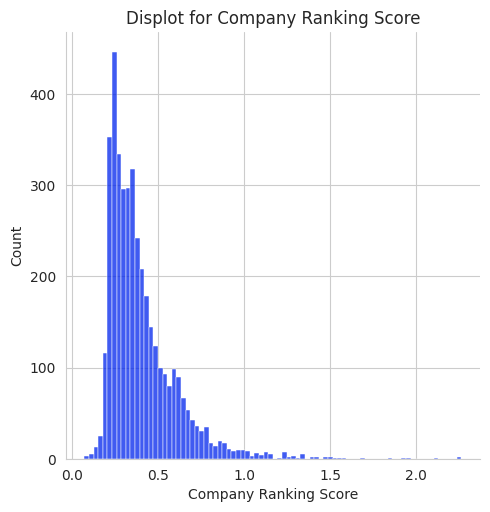

In [6]:
import matplotlib.pyplot as plt

sns.set_palette("winter")
sns.set_style("whitegrid")

sns.displot(scores_pd["total"])

plt.xlabel("Company Ranking Score")
plt.ylabel("Count")

plt.title("Displot for Company Ranking Score")
plt.show()

In [7]:
scores_pd.describe()

,merchant_abn,Customer_score,Revenue_score,Industry_score,Merchant_score,total
count,4.008000e+03,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000
mean,5.443616e+10,0.067528,0.214977,0.906232,0.157030,1.345766
std,2.599297e+10,0.100194,0.101640,0.161390,0.172078,0.250831
min,1.002328e+10,0.000000,0.000000,0.490000,0.000000,0.719527
25%,3.160456e+10,0.010567,0.175095,0.866203,0.014078,1.246535
50%,5.429183e+10,0.016475,0.201143,0.999442,0.104066,1.334260
75%,7.662666e+10,0.081366,0.236844,1.000000,0.245583,1.458751
max,9.998791e+10,1.000000,1.000000,1.000000,1.000000,3.359829


In [7]:
top100 = scores_pd.sort_values(by="total", ascending=False)["merchant_abn"][:100]

In [8]:
merchants = sp.read.option("inferSchema", True).option("header", True).csv("../data/tables/merchants_tbl_processed.csv")
merchants.head()

Row(name='Felis Limited', merchant_abn=10023283211, Description='furniture home furnishing equipment shop manufacturer except appliance', Earnings_Class='e', BNPL_Fee=0.18)

In [9]:
merged = scores.join(merchants, on="merchant_abn")
merged.show(1)

+------------+------------------+-------------------+--------------------+----------+-----------------+-------------+--------------------+--------------+--------+
|merchant_abn|    Customer_score|      Revenue_score|      Merchant_score|     total|           sector|         name|         Description|Earnings_Class|BNPL_Fee|
+------------+------------------+-------------------+--------------------+----------+-----------------+-------------+--------------------+--------------+--------+
| 10023283211|0.1447488787135831|0.18576269469586512|0.001252764400825747|0.33176434|Personal_Services|Felis Limited|furniture home fu...|             e|    0.18|
+------------+------------------+-------------------+--------------------+----------+-----------------+-------------+--------------------+--------------+--------+
only showing top 1 row



In [11]:
final = merged.orderBy("total", ascending=False)

In [12]:
top10 = pd.DataFrame(final.head(10), columns=final.columns)

In [13]:
top10.head(2)

,merchant_abn,Customer_score,Revenue_score,Merchant_score,total,sector,name,Description,Earnings_Class,BNPL_Fee
0,51267358936,0.019788,0.002734,0.047601,0.070123,Personal_Services,Consectetuer Adipiscing Industries,antique shop sale repair restoration service,b,4.56
1,76866488151,0.035717,0.030676,0.009348,0.075740,Personal_Services,Euismod Urna Company,antique shop sale repair restoration service,b,4.08


Text(0.5, 1.0, 'Top10 companies by scoring seen by sector')

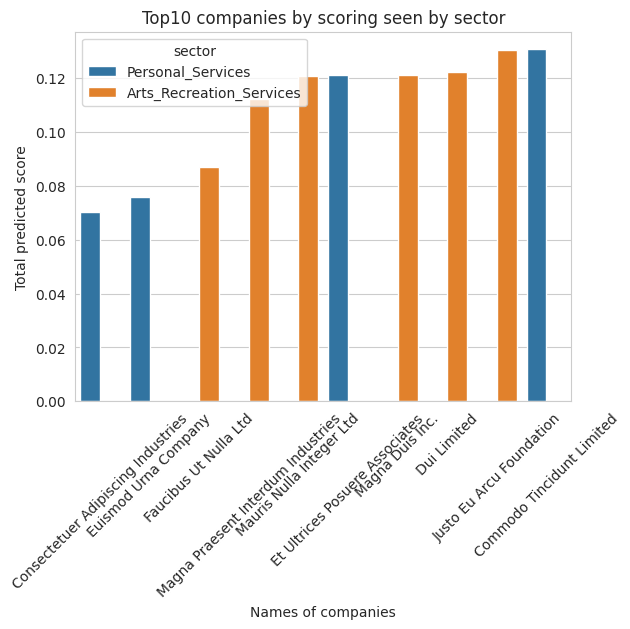

In [14]:
sns.set_palette("tab10")

sns.barplot(x="name", y="total", data=top10, hue="sector")

plt.xticks(rotation=45)

plt.xlabel("Names of companies")
plt.ylabel("Total predicted score")

plt.title("Top10 companies by scoring seen by sector")

## INSIGHTS FROM TOP 100

### Profit generated by top 100 compared to the next 200?

In [15]:
transactions = sp.read.option("inferSchema", True).parquet("../data/curated/transactions/")
transactions.show(1)

+-------+------------+------------+--------------+-----------+
|user_id|merchant_abn|dollar_value|order_datetime|   order_id|
+-------+------------+------------+--------------+-----------+
|  14935| 79417999332|      136.07|    2021-11-26|68719476736|
+-------+------------+------------+--------------+-----------+
only showing top 1 row



In [16]:
revenue = transactions.groupBy("merchant_abn").sum("dollar_value").withColumnRenamed("sum(dollar_value)", "revenue")
revenue.show(1)

+------------+-----------------+
|merchant_abn|          revenue|
+------------+-----------------+
| 83412691377|498536.9797888398|
+------------+-----------------+
only showing top 1 row



In [17]:
rev_merchant = revenue.join(merchants.drop("name", "Description"), on="merchant_abn")
rev_merchant.show(1)

+------------+-----------------+--------------+--------+
|merchant_abn|          revenue|Earnings_Class|BNPL_Fee|
+------------+-----------------+--------------+--------+
| 83412691377|498536.9797888398|             c|    2.94|
+------------+-----------------+--------------+--------+
only showing top 1 row



In [18]:
from pyspark.sql.types import FloatType

rev_merchant = rev_merchant.withColumn("profit", (col('revenue') * col("BNPL_Fee") / 100).cast(FloatType()))
rev_merchant.show(1)

+------------+-----------------+--------------+--------+---------+
|merchant_abn|          revenue|Earnings_Class|BNPL_Fee|   profit|
+------------+-----------------+--------------+--------+---------+
| 83412691377|498536.9797888398|             c|    2.94|14656.987|
+------------+-----------------+--------------+--------+---------+
only showing top 1 row



In [19]:
merged.show(1)

+------------+------------------+-------------------+--------------------+----------+-----------------+-------------+--------------------+--------------+--------+
|merchant_abn|    Customer_score|      Revenue_score|      Merchant_score|     total|           sector|         name|         Description|Earnings_Class|BNPL_Fee|
+------------+------------------+-------------------+--------------------+----------+-----------------+-------------+--------------------+--------------+--------+
| 10023283211|0.1447488787135831|0.18576269469586512|0.001252764400825747|0.33176434|Personal_Services|Felis Limited|furniture home fu...|             e|    0.18|
+------------+------------------+-------------------+--------------------+----------+-----------------+-------------+--------------------+--------------+--------+
only showing top 1 row



In [20]:
profit_table = rev_merchant.join(scores, on="merchant_abn")
profit_table.show(1)

+------------+-----------------+--------------+--------+---------+------------------+-------------------+--------------------+---------+-----------------+
|merchant_abn|          revenue|Earnings_Class|BNPL_Fee|   profit|    Customer_score|      Revenue_score|      Merchant_score|    total|           sector|
+------------+-----------------+--------------+--------+---------+------------------+-------------------+--------------------+---------+-----------------+
| 83412691377|498536.9797888398|             c|    2.94|14656.987|0.2806909814573061|0.20590820030470375|1.056201821002240...|0.4867048|Personal_Services|
+------------+-----------------+--------------+--------+---------+------------------+-------------------+--------------------+---------+-----------------+
only showing top 1 row



In [21]:
profit_table_sub = profit_table.select("merchant_abn", "profit" ,"total")
profit_table_sub.show(1)

+------------+---------+---------+
|merchant_abn|   profit|    total|
+------------+---------+---------+
| 83412691377|14656.987|0.4867048|
+------------+---------+---------+
only showing top 1 row



In [22]:
profit_table_sub.orderBy("total", ascending=False).limit(100).groupBy().sum("profit").show()

+------------------+
|       sum(profit)|
+------------------+
|216291.50048065186|
+------------------+



In [32]:
profit_table_sub.count()

4008

In [33]:
profit_table_sub_pd = profit_table_sub.toPandas()

In [34]:
profit_table_sub_pd.iloc[100:600, ].sum()["profit"]

11851505.0

Text(0.5, 1.0, 'The profit of the given set of companies')

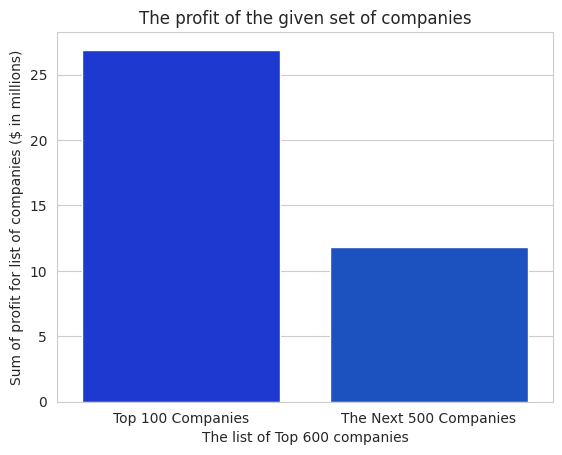

In [39]:
sns.set_palette("winter")

sns.barplot(x = ["Top 100 Companies", "The Next 500 Companies"], y=[26.899846, 11.851505])

plt.xlabel("The list of Top 600 companies")
plt.ylabel("Sum of profit for list of companies ($ in millions)")

plt.title("The profit of the given set of companies")

In [83]:
profit_table_sub.orderBy("total", ascending=False).limit(100)

+------------+---------+----------+
|merchant_abn|   profit|     total|
+------------+---------+----------+
| 83412691377|14656.987|1.48694578|
+------------+---------+----------+
only showing top 1 row



In [86]:
c_fraud = sp.read.option("inferSchema", True).parquet("../data/curated/customer_fraud")
c_fraud = c_fraud.withColumn("order_datetime", col("order_datetime").cast(DateType()))
c_fraud.show(1)

+-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|   6228|    2021-12-19|         97.62981|
+-------+--------------+-----------------+
only showing top 1 row



In [88]:
c_fraud = c_fraud.join(transactions, on=["user_id", "order_datetime"])
c_fraud.show()

+-------+--------------+-----------------+------------+------------+-----------+
|user_id|order_datetime|fraud_probability|merchant_abn|dollar_value|   order_id|
+-------+--------------+-----------------+------------+------------+-----------+
|     58|    2021-11-26|         9.241198| 43725628716|     2684.36|68719477029|
|     58|    2021-11-26|         9.241198| 45629217853|         0.2|68719477031|
|     58|    2021-11-26|         9.241198| 73499119023|        9.26|68719477033|
|     69|    2021-11-26|        15.645332| 30623214058|      111.91|68719477093|
|     69|    2021-11-26|        15.645332| 79417999332|        54.9|68719477095|
|     69|    2021-11-26|        15.645332| 18305506006|         5.2|68719477097|
|     69|    2021-11-26|        15.645332| 96244711717|       52.49|68719477099|
|     69|    2021-11-26|        15.645332| 34967436738|      4298.7|68719477101|
|     69|    2021-11-26|        15.645332| 16248082282|      361.55|68719477103|
|  15039|    2021-11-26|    

In [90]:
m_fraud = c_fraud.groupBy("merchant_abn").avg("fraud_probability")
m_fraud.show()

+------------+----------------------+
|merchant_abn|avg(fraud_probability)|
+------------+----------------------+
| 38700038932|     11.19901338719433|
| 41956465747|    15.772113800048828|
| 83412691377|    14.404884085935706|
| 73841664453|     10.65441083908081|
| 73256306726|     17.34836440616184|
| 24406529929|    12.035624408721924|
| 35344855546|    14.432141780853271|
| 19839532017|     9.432742754618326|
| 15613631617|     9.641129112243652|
| 37935728745|    39.576847076416016|
| 96946925998|     8.422162055969238|
| 28767881738|    20.463096141815186|
| 48214071373|    10.843189239501953|
| 20497101151|    12.635862557784371|
| 45925655949|    24.710105094909668|
| 35769589414|    14.390076250643343|
| 29216160692|    15.551232973734537|
| 61867784114|    13.955207347869873|
| 59128133246|     14.97108336857387|
| 87211363921|    22.365853309631348|
+------------+----------------------+
only showing top 20 rows



In [94]:
fraud_table = profit_table.join(m_fraud, on="merchant_abn").select("merchant_abn", "profit", "total", "sector", "avg(fraud_probability)")
fraud_table.show(4)

+------------+---------+----------+-----------------+----------------------+
|merchant_abn|   profit|     total|           sector|avg(fraud_probability)|
+------------+---------+----------+-----------------+----------------------+
| 83412691377|14656.987|1.48694578|Personal_Services|    14.404884085935706|
| 38700038932| 602364.3| 2.2550373|Personal_Services|     11.19901338719433|
| 35344855546|3934.3286|1.26370766|Personal_Services|    14.432141780853271|
| 15613631617|1900.6064|1.25646921|Personal_Services|     9.641129112243652|
+------------+---------+----------+-----------------+----------------------+
only showing top 4 rows



In [95]:
fraud_table_pd = fraud_table.toPandas()
fraud_table_pd.head()

,merchant_abn,profit,total,sector,avg(fraud_probability)
0,83412691377,14656.987305,1.486946,Personal_Services,14.404884
1,38700038932,602364.312500,2.255037,Personal_Services,11.199013
2,35344855546,3934.328613,1.263708,Personal_Services,14.432142
3,15613631617,1900.606445,1.256469,Personal_Services,9.641129
4,19839532017,5630.710938,1.104964,Information_Media_Telecommunications,9.432743


In [100]:
fraud_table_pd.iloc[:100,].mean()

/tmp/ipykernel_31069/3502639695.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fraud_table_pd.iloc[:100,].mean()


merchant_abn              5.115336e+10
profit                    3.294384e+04
total                     1.309961e+00
avg(fraud_probability)    1.451704e+01
dtype: float64

In [101]:
fraud_table_pd.iloc[100:600,].mean()

/tmp/ipykernel_31069/722460129.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fraud_table_pd.iloc[100:600,].mean()


merchant_abn              5.442669e+10
profit                    3.336612e+04
total                     1.339912e+00
avg(fraud_probability)    1.462152e+01
dtype: float64

In [35]:
sector_analysis = profit_table.select("merchant_abn", "total", "sector").orderBy("total", ascending=False)
sector_analysis.show(2)

+------------+----------+--------------------+
|merchant_abn|     total|              sector|
+------------+----------+--------------------+
| 24852446429|2.26287681|Administrative_Su...|
| 43186523025|2.23809834|Administrative_Su...|
+------------+----------+--------------------+
only showing top 2 rows



In [48]:
sec_anal_pd = sector_analysis.limit(100).toPandas()
to_pie = sec_anal_pd["sector"].value_counts()

In [59]:
to_pie.index

Index(['Administrative_Support_Services', 'Personal_Services',
       'Information_Media_Telecommunications', 'Arts_Recreation_Services'],
      dtype='object')

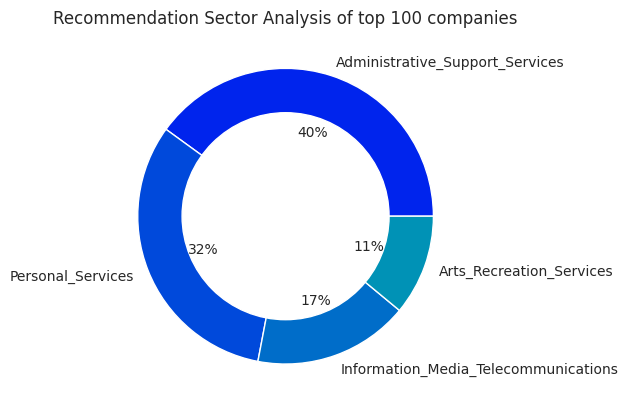

In [58]:
plt.pie(to_pie.values, labels=to_pie.index, autopct='%1.0f%%', startangle=0)
my_circle = plt.Circle((0,0), 0.7, color="white")
p=plt.gcf()
plt.title("Recommendation Sector Analysis of top 100 companies")
p.gca().add_artist(my_circle)

plt.show()

In [36]:
# EARNINGS CLASS RECOMMENDATION

e_class = sector_analysis.limit(100).join(merchants, on="merchant_abn") 
e_class.show(2)

+------------+----------+--------------------+--------------+--------------------+--------------+--------+
|merchant_abn|     total|              sector|          name|         Description|Earnings_Class|BNPL_Fee|
+------------+----------+--------------------+--------------+--------------------+--------------+--------+
| 10346855916|1.01090918|Administrative_Su...|Odio Institute|equipment tool fu...|             b|    3.57|
| 11439466003|0.99770108|   Personal_Services|Blandit At LLC|           shoe shop|             a|    5.71|
+------------+----------+--------------------+--------------+--------------------+--------------+--------+
only showing top 2 rows



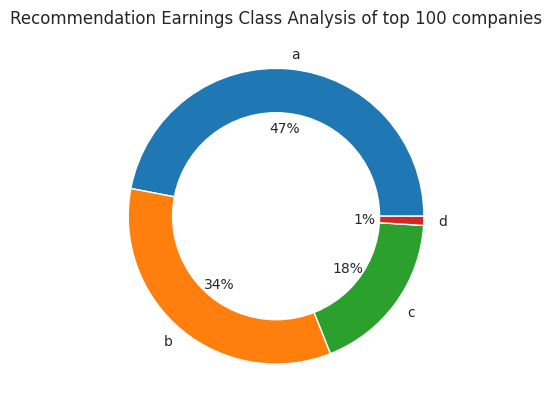

In [37]:
e_class_pd = e_class.toPandas()
to_pie = e_class_pd["Earnings_Class"].value_counts()

plt.pie(to_pie.values, labels=to_pie.index, autopct='%1.0f%%', startangle=0)
my_circle = plt.Circle((0,0), 0.7, color="white")
p=plt.gcf()
plt.title("Recommendation Earnings Class Analysis of top 100 companies")
p.gca().add_artist(my_circle)

plt.show()

In [26]:
merchant_fraud = sp.read.option("inferSchema", True).option("header", True).csv("../data/tables/merchant_fraud_probability.csv")
merchant_fraud = merchant_fraud.withColumn("order_datetime", col("order_datetime").cast(DateType()))
merchant_fraud.show(1)

+------------+--------------+------------------+
|merchant_abn|order_datetime| fraud_probability|
+------------+--------------+------------------+
| 19492220327|    2021-11-28|44.403658647495355|
+------------+--------------+------------------+
only showing top 1 row



In [29]:
fraud100 = profit_table.orderBy("total", ascending=False).limit(100).join(merchant_fraud, on="merchant_abn")

In [30]:
fraud100.count()

34

In [31]:
fraud100_pd = fraud100.toPandas()
fraud100_pd.head()

,merchant_abn,revenue,Earnings_Class,BNPL_Fee,profit,Customer_score,Revenue_score,Merchant_score,total,sector,order_datetime,fraud_probability
0,21439773999,9.426656e+06,a,6.10,575026.00000,0.574197,0.981726,0.139616,1.695539,Information_Media_Telecommunications,2021-11-26,28.504479
1,94493496784,9.115636e+06,a,5.65,515033.40625,0.506634,0.955355,0.021901,1.483890,Personal_Services,2021-11-26,30.579032
2,48534649627,9.408958e+06,a,6.64,624754.81250,0.422008,1.000000,0.008034,1.430041,Personal_Services,2021-11-27,28.337370
3,48534649627,9.408958e+06,a,6.64,624754.81250,0.422008,1.000000,0.008034,1.430041,Personal_Services,2021-11-29,28.360522
4,48534649627,9.408958e+06,a,6.64,624754.81250,0.422008,1.000000,0.008034,1.430041,Personal_Services,2021-11-26,29.005907


Text(0.5, 1.0, 'Scores vs Fraud Probability')

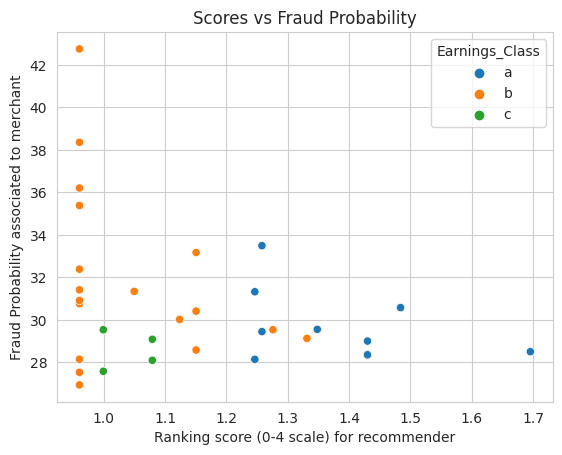

In [38]:
sns.scatterplot(x="total", y="fraud_probability", hue="Earnings_Class", data=fraud100_pd)

plt.xlabel("Ranking score (0-4 scale) for recommender")
plt.ylabel("Fraud Probability associated to merchant")

plt.title("Scores vs Fraud Probability")